#### Install libraries on the host

In [1]:
#%pip install pandas seaborn xgboost scikit-learn

#### import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [4]:
def extract_datetime_features(df):
    """
        Extract year, month, day, day_of_month, day_of_week
                day_of_year, week_of_year, quarter,
                hour, minute
        from index that is in datetime format
    """
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week
    df['quarter'] = df.index.quarter
    df['hour'] = df.index.hour
    df['minute'] = df.index.hour   
    
    return df

#### onboard data and perform some pre-processing

In [5]:
# load ferry usage data

df = pd.read_csv("data/toronto_island_ferry_ticket_counts.csv")

In [6]:
# rename columns and drop extra columns

df = df.rename(columns={'Timestamp': 'timestamp', 'Redemption Count': 'redemption_count'})
df.drop(['_id','Sales Count'], axis=1, inplace=True)

In [7]:
# setting timestamp as index then converting index as timestamp

df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)

#### EDA and cleanup

In [8]:
df.head()

,redemption_count
timestamp,
2025-03-21 08:45:00,2
2025-03-21 08:30:00,9
2025-03-21 08:15:00,32
2025-03-21 08:00:00,6
2025-03-21 07:45:00,0


In [9]:
# we have observations for every 15 minutes

In [10]:
# let's check for nulls 

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240821 entries, 2025-03-21 08:45:00 to 2015-05-01 13:30:00
Data columns (total 1 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   redemption_count  240821 non-null  int64
dtypes: int64(1)
memory usage: 3.7 MB


In [11]:
# looks like we don't have any nulls
# let's start plotting the data and perform further analysis

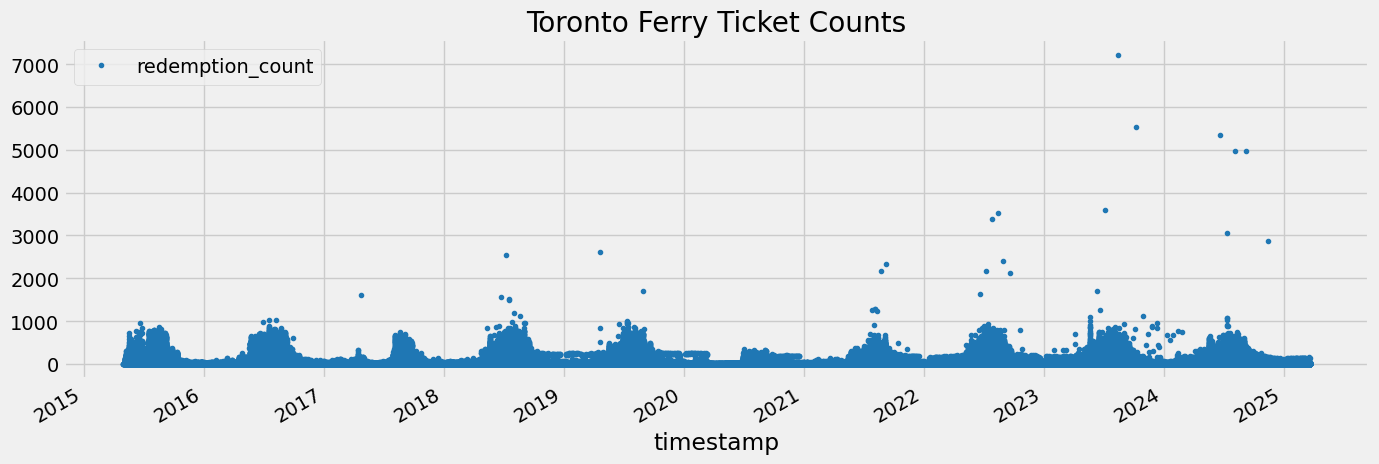

In [12]:
# plotting the initial distribution of our full dataset

df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Toronto Ferry Ticket Counts')
plt.show()

In [13]:
# removing partial years 2015 and 2025

df = df.loc[df.index.year < 2025]
df = df.loc[df.index.year > 2015]
df.groupby(df.index.year).count()

,redemption_count
timestamp,
2016,23240
2017,22101
2018,24665
2019,24670
2020,22741
2021,25231
2022,25733
2023,26295
2024,26261


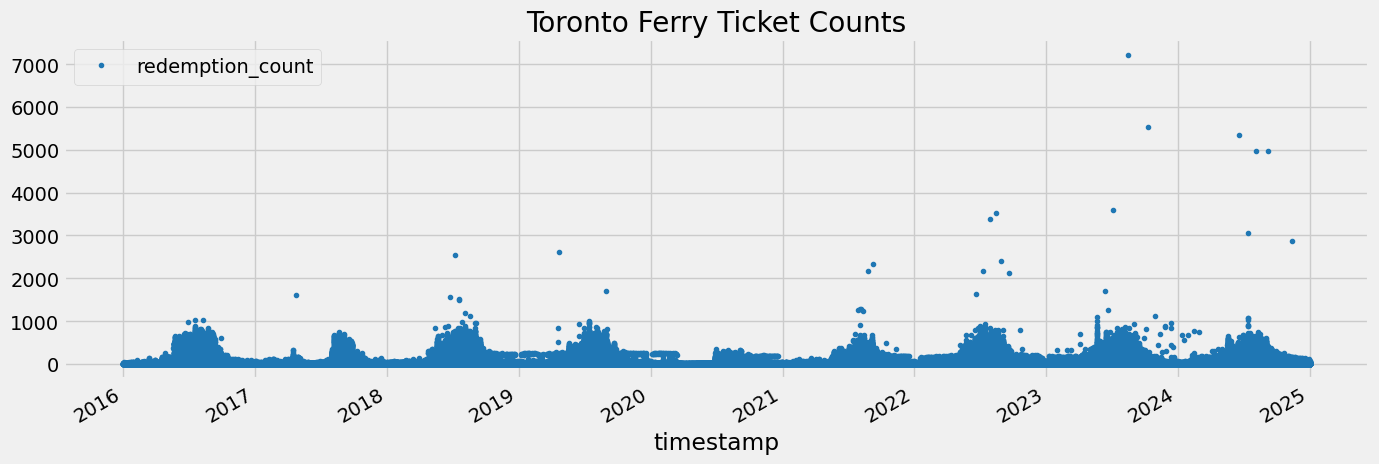

In [14]:
# plotting the initial distribution of our full dataset again

df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Toronto Ferry Ticket Counts')
plt.show()

In [15]:
# we see some possible outliers. we may need to deal with them soon

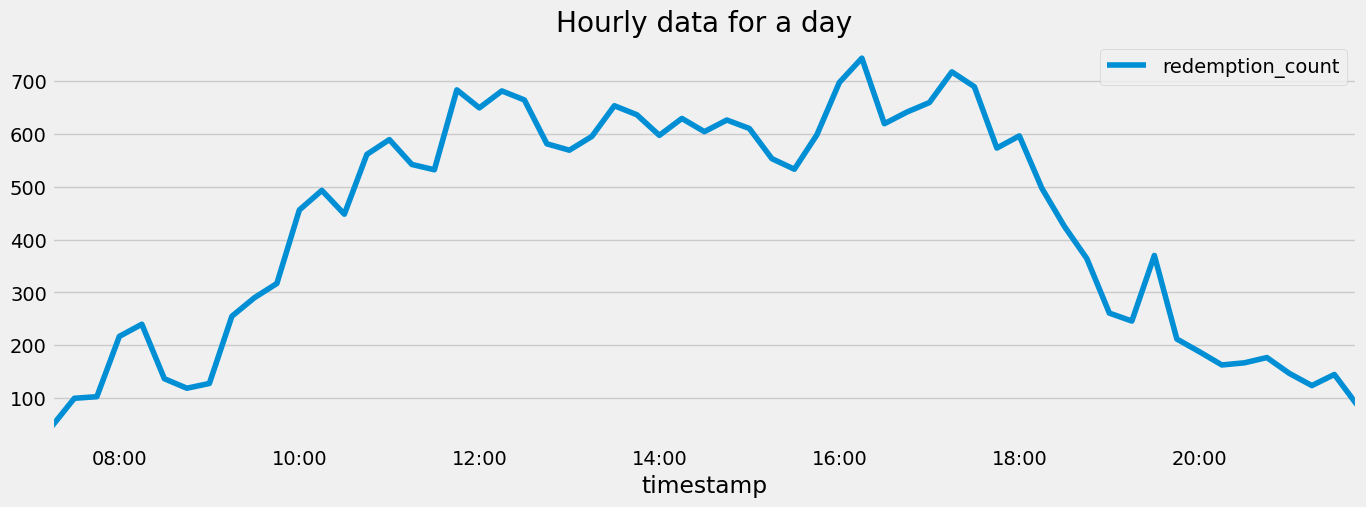

In [16]:
# let's have a look at an hourly slice for a day

df.loc[(df.index > '07-01-2018 07:00:00') & (df.index < '07-01-2018 22:00:00')] \
    .plot(figsize=(15, 5), title='Hourly data for a day')
plt.show()

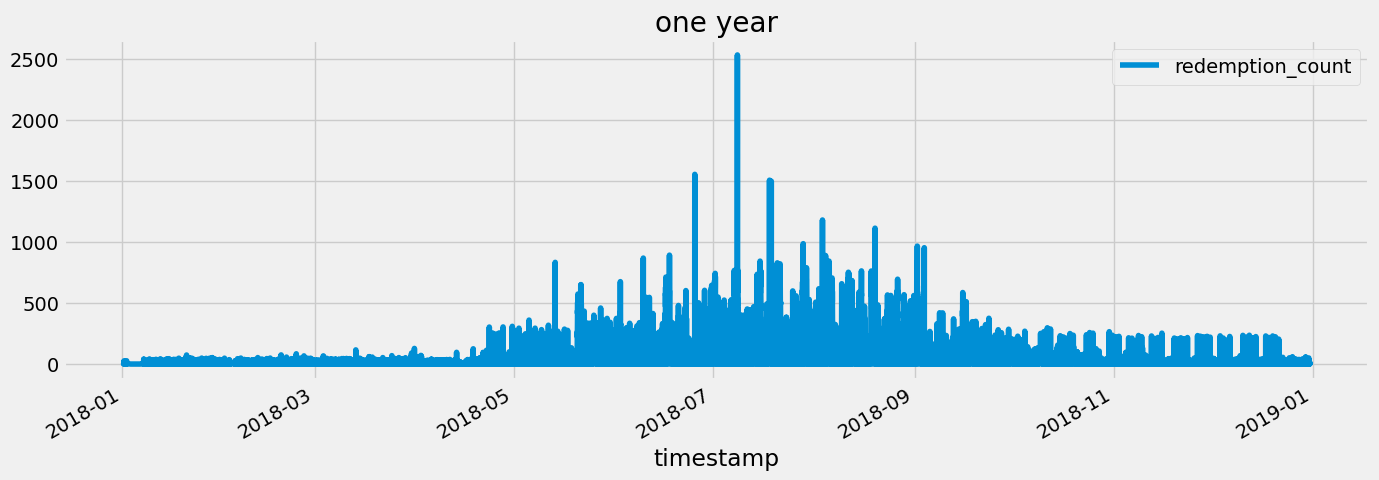

In [17]:
# and here is a plot of a year's data

df.loc[(df.index > '01-01-2018') & (df.index < '12-31-2018')] \
    .plot(figsize=(15, 5), title='one year')
plt.show()

In [18]:
# since we have hourly data, let's extract some datetime features
# this will help us further analyze the data

df = extract_datetime_features(df)
df

,redemption_count,year,month,day_of_month,day_of_week,day_of_year,week_of_year,quarter,hour,minute
timestamp,,,,,,,,,,
2024-12-31 23:30:00,6,2024,12,31,1,366,1,4,23,23
2024-12-31 23:15:00,0,2024,12,31,1,366,1,4,23,23
2024-12-31 23:00:00,6,2024,12,31,1,366,1,4,23,23
2024-12-31 22:45:00,0,2024,12,31,1,366,1,4,22,22
2024-12-31 22:30:00,1,2024,12,31,1,366,1,4,22,22
...,...,...,...,...,...,...,...,...,...,...
2016-01-01 09:30:00,0,2016,1,1,4,1,53,1,9,9
2016-01-01 09:00:00,2,2016,1,1,4,1,53,1,9,9
2016-01-01 08:15:00,1,2016,1,1,4,1,53,1,8,8


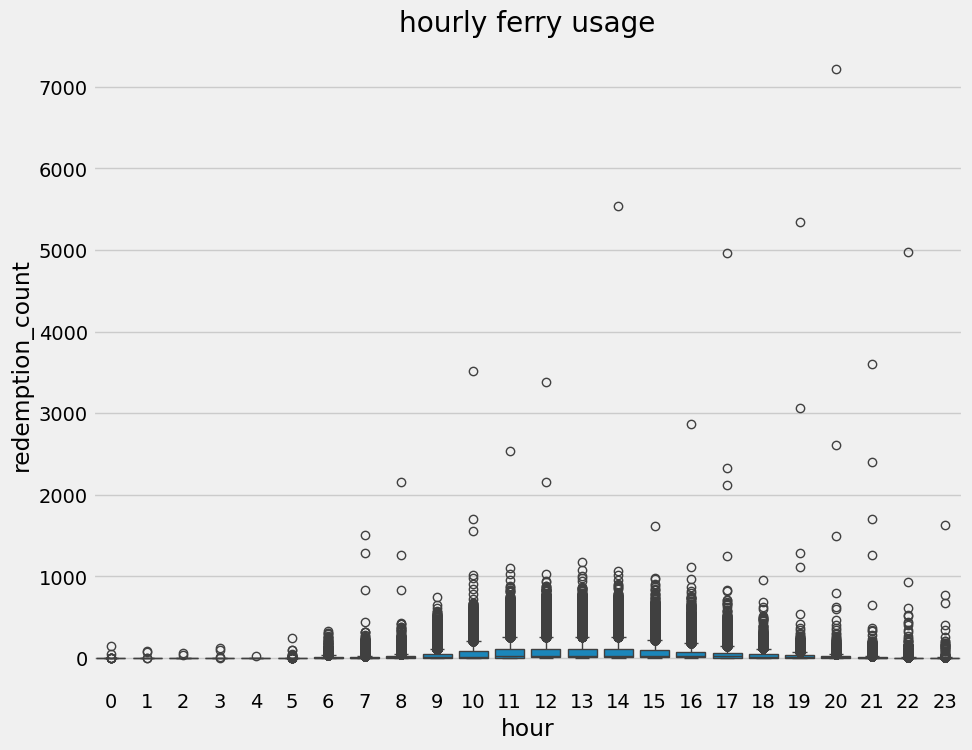

In [19]:
# let's plot hourly data

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='redemption_count')
ax.set_title('hourly ferry usage')
plt.show()

In [20]:
# clearly we have some outliers. 
# let's look at an anova table

df.describe()

,redemption_count,year,month,day_of_month,day_of_week,day_of_year,week_of_year,quarter,hour,minute
count,220937.000000,220937.000000,220937.000000,220937.000000,220937.000000,220937.000000,220937.0,220937.000000,220937.000000,220937.000000
mean,46.562187,2020.123850,6.683933,15.752821,3.008111,188.083191,27.231365,2.561386,13.656205,13.656205
std,101.554887,2.584422,3.282680,8.815486,1.989569,100.307370,14.3231,1.071125,5.659833,5.659833
min,0.000000,2016.000000,1.000000,1.000000,0.000000,1.000000,1.0,1.000000,0.000000,0.000000
25%,3.000000,2018.000000,4.000000,8.000000,1.000000,106.000000,15.0,2.000000,9.000000,9.000000
50%,10.000000,2020.000000,7.000000,16.000000,3.000000,193.000000,28.0,3.000000,14.000000,14.000000
75%,37.000000,2022.000000,9.000000,23.000000,5.000000,270.000000,39.0,3.000000,18.000000,18.000000
max,7216.000000,2024.000000,12.000000,31.000000,6.000000,366.000000,53.0,4.000000,23.000000,23.000000


In [21]:
# As we can see from the redemption_count column, there are some extreme outliers. 
# Let's try to clean that up using IQR. 

Q1 = df['redemption_count'].quantile(0.25)
Q3 = df['redemption_count'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

In [22]:
print(f"lower: {lower}, upper: {upper}" )

lower: -48.0, upper: 88.0


In [23]:
# removing outlier values outside partial years 2015 and 2025

df = df.loc[df.redemption_count > lower]
df = df.loc[df.redemption_count < upper]

In [24]:
df.describe()

,redemption_count,year,month,day_of_month,day_of_week,day_of_year,week_of_year,quarter,hour,minute
count,189493.000000,189493.000000,189493.000000,189493.000000,189493.000000,189493.000000,189493.0,189493.000000,189493.000000,189493.000000
mean,15.157811,2020.104959,6.578612,15.732961,2.929306,184.890904,26.797987,2.525824,13.697604,13.697604
std,18.998333,2.550867,3.480102,8.786896,1.966970,106.400802,15.196677,1.130646,5.999604,5.999604
min,0.000000,2016.000000,1.000000,1.000000,0.000000,1.000000,1.0,1.000000,0.000000,0.000000
25%,2.000000,2018.000000,4.000000,8.000000,1.000000,92.000000,14.0,2.000000,9.000000,9.000000
50%,7.000000,2020.000000,7.000000,16.000000,3.000000,183.000000,27.0,3.000000,14.000000,14.000000
75%,20.000000,2022.000000,10.000000,23.000000,5.000000,280.000000,40.0,4.000000,19.000000,19.000000
max,87.000000,2024.000000,12.000000,31.000000,6.000000,366.000000,53.0,4.000000,23.000000,23.000000


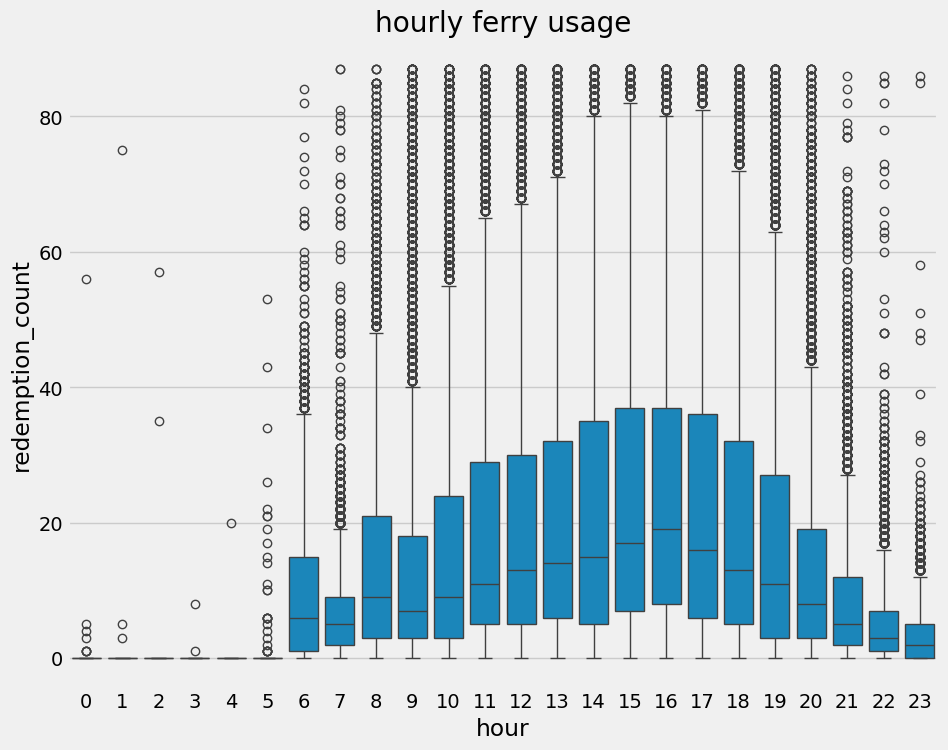

In [25]:
# with outliers removed, let's plot again

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='redemption_count')
ax.set_title('hourly ferry usage')
plt.show()

In [26]:
# we still have some outliers between midnight and 5am
# let's come back to that one

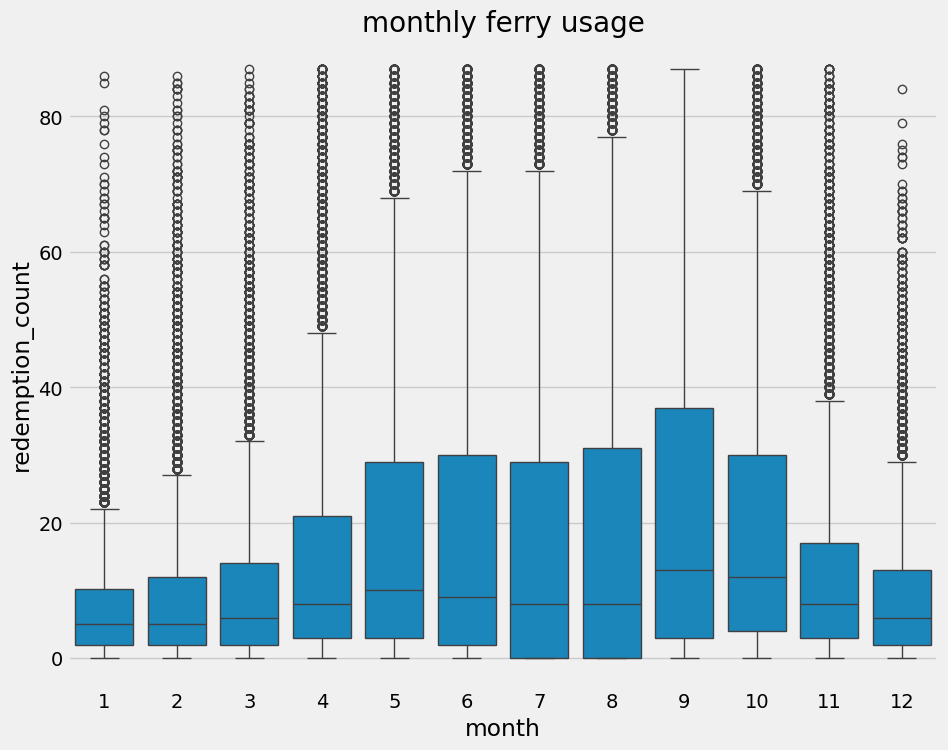

In [27]:
# plot monthly ferry usage

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='redemption_count')
ax.set_title('monthly ferry usage')
plt.show()

In [28]:
# this looks good, no major issues

In [29]:
# let's remove any records before 5am and replot

df = df.loc[df.hour > 5]


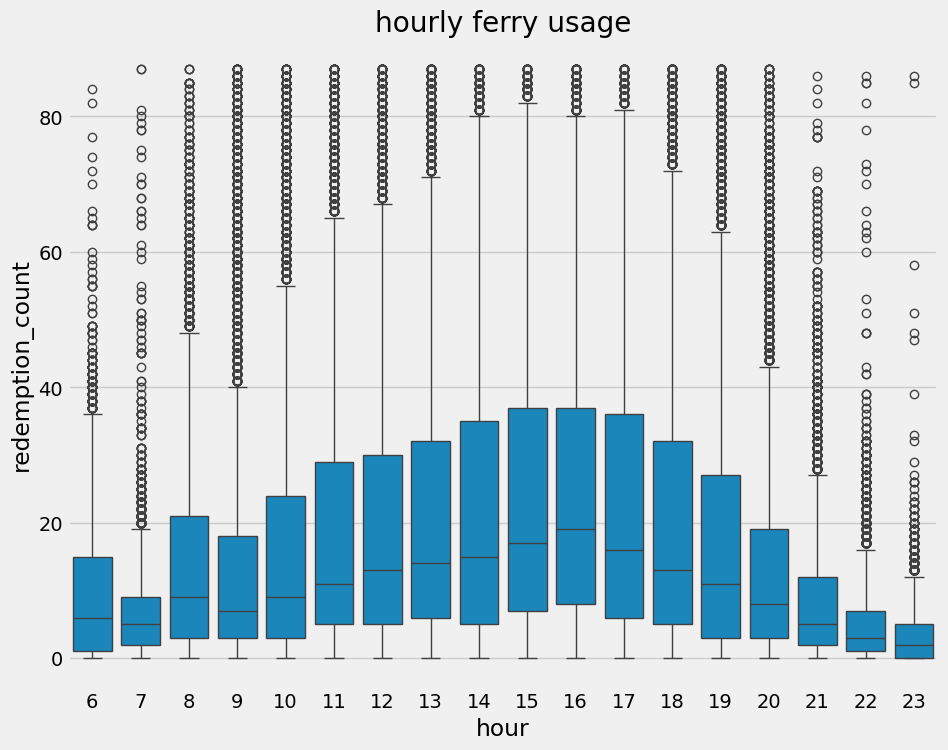

In [30]:
# replot after remove 0 - 5 hours

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='redemption_count')
ax.set_title('hourly ferry usage')
plt.show()

In [31]:
# okay, this is much cleaner, next we train model

#### train and test

In [32]:
# training set is [2016 - 2023]
# test set is > 2023

train = df.loc[df.index < '01-01-2024']
test = df.loc[df.index >= '01-01-2024']

# fig, ax = plt.subplots(figsize=(15, 5))
# train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
# test.plot(ax=ax, label='Test Set')
# ax.axvline('01-01-2024', color='black', ls='--')
# ax.legend(['Training Set', 'Test Set'])
# plt.show()

In [33]:
FEATURES = ['day_of_year', 'hour', 'day_of_week', 'quarter', 'month', 'year']
TARGET = 'redemption_count'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [34]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:24.28063	validation_1-rmse:28.15568
[100]	validation_0-rmse:17.77210	validation_1-rmse:20.76412


/Users/firozk/Documents/school/transit-forecast/.venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [16:04:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:16.12179	validation_1-rmse:17.96062
[300]	validation_0-rmse:15.48065	validation_1-rmse:16.73841
[400]	validation_0-rmse:15.14359	validation_1-rmse:16.02642
[500]	validation_0-rmse:14.92867	validation_1-rmse:15.61288
[600]	validation_0-rmse:14.75471	validation_1-rmse:15.35933
[700]	validation_0-rmse:14.60452	validation_1-rmse:15.16802
[800]	validation_0-rmse:14.48922	validation_1-rmse:15.03083
[900]	validation_0-rmse:14.38760	validation_1-rmse:14.92893
[999]	validation_0-rmse:14.30636	validation_1-rmse:14.83031


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

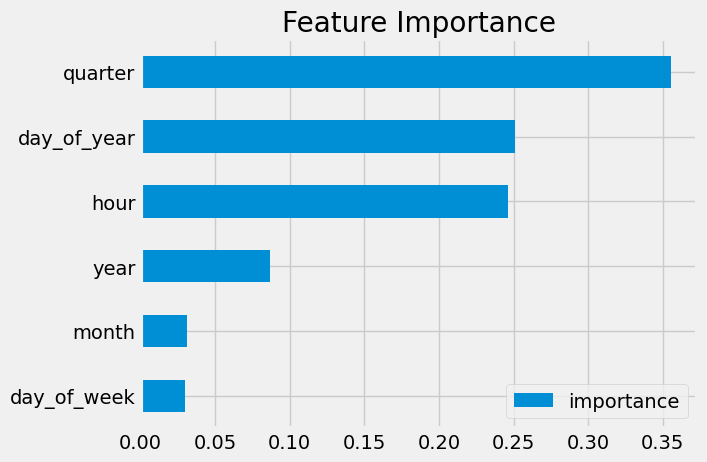

In [35]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

/var/folders/vs/7xtngmk97_368ytqy3yj8f6m0000gn/T/ipykernel_4342/4023921009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


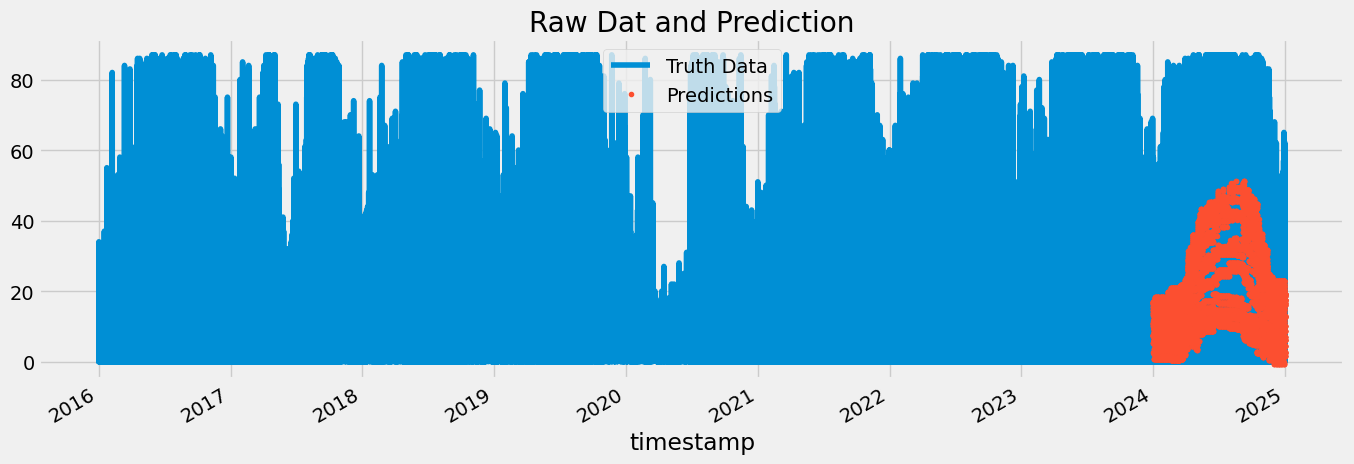

In [36]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['redemption_count']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

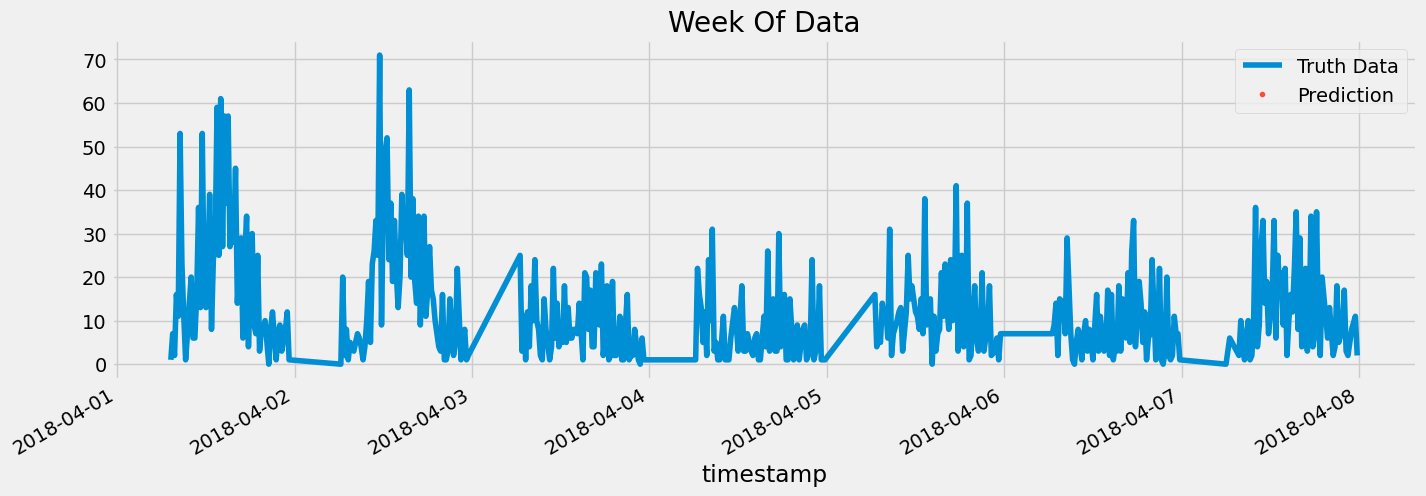

In [37]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['redemption_count'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

#### RMSE

In [38]:
score = np.sqrt(mean_squared_error(test['redemption_count'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 14.83


In [39]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2024-07-10    21.015122
2024-05-02    20.923778
2024-03-30    19.817264
2024-07-16    19.420949
2024-03-13    19.082908
2024-04-06    18.731630
2024-04-14    18.690246
2024-05-07    18.620986
2024-06-06    18.381669
2024-06-15    18.174068
Name: error, dtype: float64

#### MAPE

In [40]:
mean_absolute_percentage_error(test['redemption_count'], test['prediction'])

1892655722135552.0